---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

> In this notebook, we take a look at some of the derived quantities for sea surface height (SSH). These are physically meaningful quantities like velocity and vorticity. From these, we can visually assess how well our reconstruction methods perform.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-01"])


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.40
    decode_times: bool = False
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["ssh"])
    paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013*"
    
    

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [37]:
select = {"time": slice("2013-01-01", "2013-06-01")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-0.9361705806054363, 1.0, (32, 3), -1.0, 0.7880794701986757, (32, 1))

In [38]:
xrda = dm.load_xrds()
xrda

<xarray.Dataset>
Dimensions:  (time: 152, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-06-01
Data variables:
    ssh      (time, lat, lon) float64 0.5287 0.5287 0.523 ... -0.05293 -0.05293

In [8]:
import jejeqx._src.transforms.xarray.geostrophic as geocalc
import jejeqx._src.viz.geostrophic as geoplot
from jejeqx._src.viz.utils import get_cbar_label

In [9]:
def calculate_physical_quantities(da):
    
    # SSH
    ds = geocalc.get_ssh_dataset(da)
    
    # Stream Function
    ds = geocalc.calculate_streamfunction(ds, "ssh")
    
    # U,V Velocities
    ds = geocalc.calculate_velocities_sf(ds, "psi")
    
    # Kinetic Energy
    ds = geocalc.calculate_kinetic_energy(ds, ["u","v"])
    
    # Relative Vorticity
    ds = geocalc.calculate_relative_vorticity_uv(ds, ["u","v"], normalized=True)
    
    # Strain
    ds = geocalc.calculate_strain_magnitude(ds, ["u","v"], normalized=True)
    
    
    return ds

In [40]:
ds_natl60 = calculate_physical_quantities(xrda.ssh)

In [10]:
import cmocean as cmo

def plot_analysis_vars(ds):
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
    
    # SSH
    cbar_kwargs = {"label": get_cbar_label(ds.ssh)}
    ds.ssh.plot.pcolormesh(ax=ax[0,0], cmap="viridis", cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    
    # U
    cbar_kwargs = {"label": get_cbar_label(ds.u)}
    ds.u.plot.pcolormesh(ax=ax[0,1], cmap="gray", cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    
    # v
    cbar_kwargs = {"label": get_cbar_label(ds.v)}
    ds.v.plot.pcolormesh(ax=ax[0,2], cmap="gray", cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    
    # Kinetic Energy
    cbar_kwargs = {"label": get_cbar_label(ds.ke)}
    ds.ke.plot.pcolormesh(ax=ax[1,0], cmap="YlGnBu_r", cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    
    # Relative Vorticity
    cbar_kwargs = {"label": get_cbar_label(ds.vort_r)}
    ds.vort_r.plot.pcolormesh(ax=ax[1,1], cmap="RdBu_r", cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    
    
    # STRAIN
    cbar_kwargs = {"label": get_cbar_label(ds.strain)}
    ds.strain.plot.pcolormesh(ax=ax[1,2], cmap=cmo.cm.speed, cbar_kwargs=cbar_kwargs)
    plt.tight_layout()
    return fig, ax

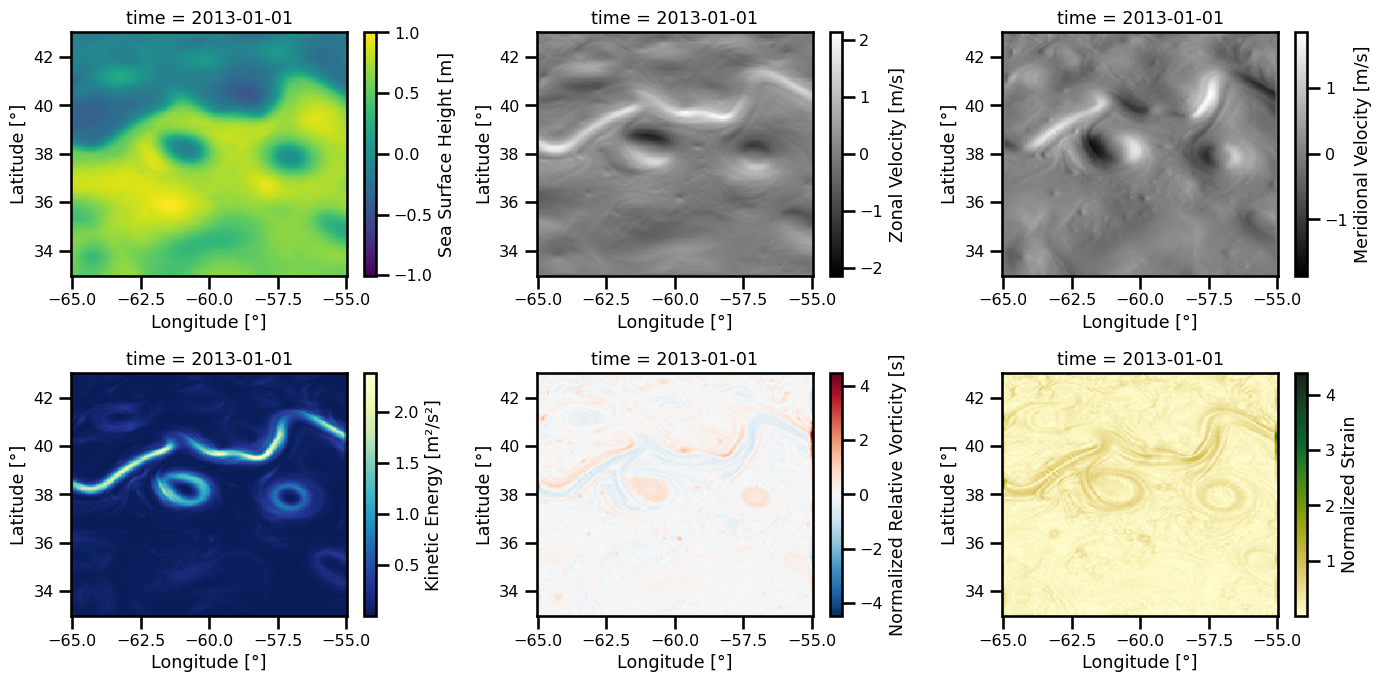

In [12]:
fig, ax = plot_analysis_vars(ds_natl60.isel(time=0))
plt.show()

In [13]:
from jejeqx._src.transforms.xarray.grid import latlon_deg2m, time_rescale

ds_psd_natl60 = latlon_deg2m(ds_natl60, mean=True)
ds_psd_natl60 = time_rescale(ds_psd_natl60, 1, "D")
ds_psd_natl60

<xarray.Dataset>
Dimensions:  (lon: 201, lat: 201, time: 32)
Coordinates:
  * lon      (lon) float64 0.0 4.376e+03 8.751e+03 ... 8.707e+05 8.751e+05
  * lat      (lat) float64 0.0 5.56e+03 1.112e+04 ... 1.106e+06 1.112e+06
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0 31.0
Data variables:
    ssh      (time, lat, lon) float64 <Quantity([[[ 0.52873772  0.52873772  0...
    psi      (time, lat, lon) float64 <Quantity([[[ 57821.90125565  57821.901...
    u        (time, lat, lon) float64 <Quantity([[[ 0.09819786  0.09819786  0...
    v        (time, lat, lon) float64 <Quantity([[[ 0.06750432 -0.06750432 -0...
    ke       (time, lat, lon) float64 <Quantity([[[7.09982675e-03 7.09982675e...
    vort_r   (time, lat, lon) float64 <Quantity([[[ 1.06998155e-01  2.8051866...
    strain   (time, lat, lon) float64 <Quantity([[[0.92528214 0.75184444 0.53...

## IsoTropic PSD

In [102]:
from jejeqx._src.transforms.xarray.psd import psd_spacetime, psd_isotropic, psd_average_freq


def calculate_isotropic_psd(ds, freq_dt=1, freq_unit="D"):
    
    ds = latlon_deg2m(ds, mean=True)
    ds = time_rescale(ds, freq_dt, freq_unit)
    
    # calculate isotropic PSDs
    ds_psd = xr.Dataset()
    ds_psd["ssh"] = psd_average_freq(psd_isotropic(ds.ssh, ["lat", "lon"]))
    ds_psd["u"] = psd_average_freq(psd_isotropic(ds.u, ["lat", "lon"]))
    ds_psd["v"] = psd_average_freq(psd_isotropic(ds.v, ["lat", "lon"]))
    ds_psd["ke"] = psd_average_freq(psd_isotropic(ds.ke, ["lat", "lon"]))
    ds_psd["vort_r"] = psd_average_freq(psd_isotropic(ds.vort_r, ["lat", "lon"]))
    ds_psd["strain"] = psd_average_freq(psd_isotropic(ds.strain, ["lat", "lon"]))

    return ds_psd

In [103]:
ds_psd_natl60 = calculate_isotropic_psd(ds_natl60)


<xarray.Dataset>
Dimensions:  (freq_r: 62)
Coordinates:
  * freq_r   (freq_r) float64 1.095e-06 2.407e-06 ... 8.754e-05 8.898e-05
Data variables:
    ssh      (freq_r) float64 3.038e+03 3.954e+03 ... 0.001632 0.001572
    u        (freq_r) float64 1.295e+03 4.874e+03 6.984e+03 ... 0.2231 0.1965
    v        (freq_r) float64 619.7 4.592e+03 5.394e+03 ... 0.6338 0.5804 0.5374
    ke       (freq_r) float64 1.612e+03 1.957e+03 2.052e+03 ... 0.4921 0.4356
    vort_r   (freq_r) float64 19.96 331.3 805.5 862.2 ... 7.137 6.392 5.75 5.094
    strain   (freq_r) float64 445.9 534.6 347.1 279.7 ... 8.293 7.923 7.564

In [108]:
ds_psd_natl60.ssh

<xarray.DataArray 'ssh' (freq_time: 75, freq_lon: 100)>
array([[4.28943790e+04, 1.59210261e+05, 4.21086560e+04, ...,
        7.72608624e-04, 8.18593543e-04, 6.60044449e-04],
       [1.16682400e+05, 1.36167012e+05, 1.80897225e+04, ...,
        8.54381255e-04, 7.55321944e-04, 7.35028833e-04],
       [5.54774813e+04, 5.31276318e+04, 3.25824786e+04, ...,
        7.46714282e-04, 7.63845350e-04, 6.50564938e-04],
       ...,
       [2.58552502e+00, 2.73349767e+00, 2.01406501e+00, ...,
        5.64655595e-04, 6.34049748e-04, 5.79308110e-04],
       [3.79778099e+00, 2.58258490e+00, 2.00880376e+00, ...,
        6.09531914e-04, 6.28782210e-04, 6.36972392e-04],
       [2.64247417e+00, 2.07965195e+00, 1.97961049e+00, ...,
        6.01260455e-04, 5.53096107e-04, 6.14005950e-04]])
Coordinates:
  * freq_time  (freq_time) float64 0.006579 0.01316 0.01974 ... 0.4868 0.4934
  * freq_lon   (freq_lon) float64 1.137e-06 2.274e-06 ... 0.0001126 0.0001137

In [104]:
import cmocean as cmo
from jejeqx._src.viz.xarray.psd import plot_psd_isotropic, plot_psd_spacetime_wavenumber

def plot_analysis_psd_iso(ds):
    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,7))
    
    # SSH
    scale = "km"
    units = "$m^{2}$/cycles/m"
    ax[0,0] = plot_psd_isotropic(ds.ssh, units=units, scale=scale, ax=ax[0,0])

    
    # U
    scale = "km"
    units = "U-Velocity" #"$m^{2}$/cycles/m"
    ax[0,1] = plot_psd_isotropic(ds.u, units=units, scale=scale, ax=ax[0,1])
    
    # v
    scale = "km"
    units = "V-Velocity" #"$m^{2}$/cycles/m"
    ax[0,2] = plot_psd_isotropic(ds.v, units=units, scale=scale, ax=ax[0,2])
    
    # Kinetic Energy
    scale = "km"
    units = "Kinetic Energy" #"$m^{2}$/cycles/m"
    ax[1,0] = plot_psd_isotropic(ds.ke, units=units, scale=scale, ax=ax[1,0])
    
    # Relative Vorticity
    scale = "km"
    units = "U-Velocity" #"$m^{2}$/cycles/m"
    ax[1,1] = plot_psd_isotropic(ds.vort_r, units=units, scale=scale, ax=ax[1,1])
    
    
    # STRAIN
    scale = "km"
    units = "Strain" #"$m^{2}$/cycles/m"
    ax[1,2] = plot_psd_isotropic(ds.u, units=units, scale=scale, ax=ax[1,2])
    
    
    plt.tight_layout()
    return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


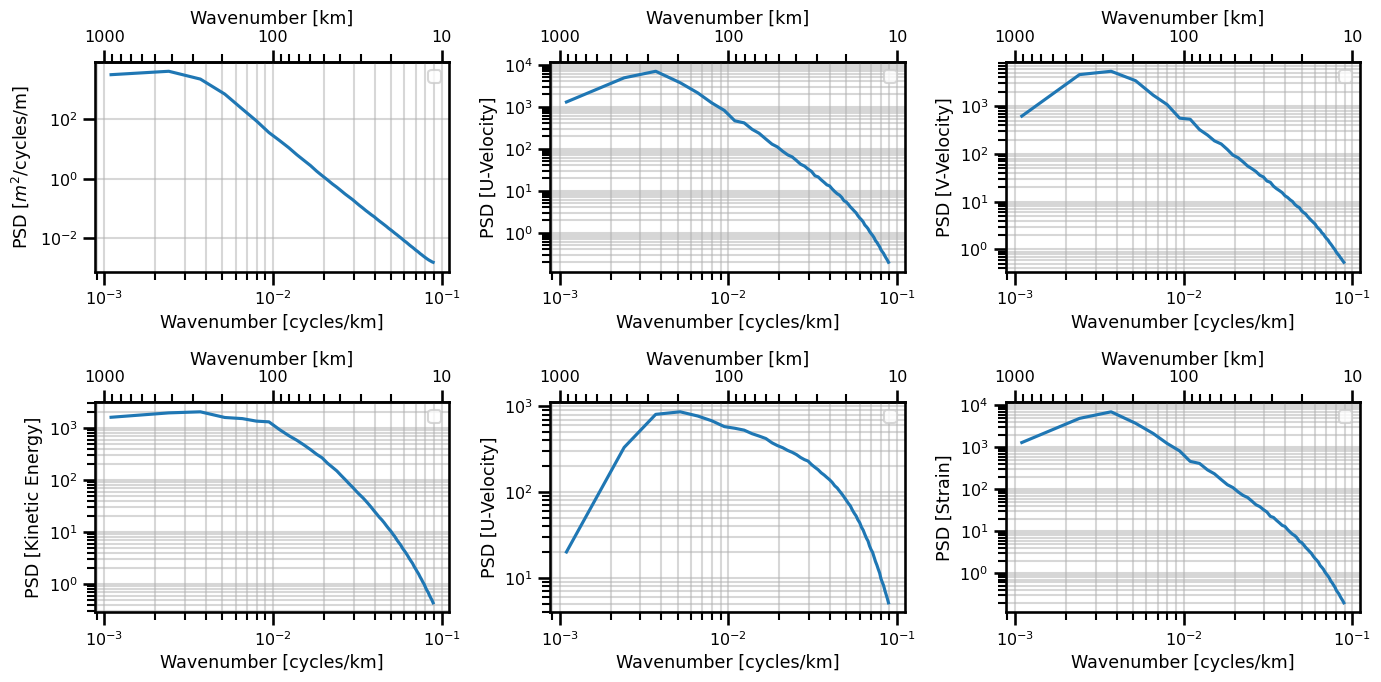

In [105]:
fig, ax = plot_analysis_psd_iso(ds_psd_natl60)
plt.show()

In [106]:
from jejeqx._src.transforms.xarray.psd import psd_spacetime, psd_isotropic, psd_average_freq


def calculate_spacetime_psd(ds, freq_dt=1, freq_unit="D"):
    
    ds = latlon_deg2m(ds, mean=True)
    ds = time_rescale(ds, freq_dt, freq_unit)
    
    # calculate isotropic PSDs
    ds_psd = xr.Dataset()
    ds_psd["ssh"] = psd_average_freq(psd_spacetime(ds.ssh, ["time", "lon"]))
    ds_psd["u"] = psd_average_freq(psd_spacetime(ds.u, ["time", "lon"]))
    ds_psd["v"] = psd_average_freq(psd_spacetime(ds.v, ["time", "lon"]))
    ds_psd["ke"] = psd_average_freq(psd_spacetime(ds.ke, ["time", "lon"]))
    ds_psd["vort_r"] = psd_average_freq(psd_spacetime(ds.vort_r, ["time", "lon"]))
    ds_psd["strain"] = psd_average_freq(psd_spacetime(ds.strain, ["time", "lon"]))

    return ds_psd

In [107]:

ds_psd_natl60 = calculate_spacetime_psd(ds_natl60)
ds_psd_natl60

<xarray.Dataset>
Dimensions:    (freq_time: 75, freq_lon: 100)
Coordinates:
  * freq_time  (freq_time) float64 0.006579 0.01316 0.01974 ... 0.4868 0.4934
  * freq_lon   (freq_lon) float64 1.137e-06 2.274e-06 ... 0.0001126 0.0001137
Data variables:
    ssh        (freq_time, freq_lon) float64 4.289e+04 1.592e+05 ... 0.000614
    u          (freq_time, freq_lon) float64 1.169e+05 2.071e+05 ... 0.1165
    v          (freq_time, freq_lon) float64 3.579e+04 3.749e+05 ... 0.0002248
    ke         (freq_time, freq_lon) float64 3.929e+04 7.548e+04 ... 0.05342
    vort_r     (freq_time, freq_lon) float64 1.936e+04 4.151e+04 ... 0.3735
    strain     (freq_time, freq_lon) float64 9.339e+03 1.697e+04 ... 5.289 4.699

In [125]:
ds_psd_natl60 = calculate_spacetime_psd(ds_natl60)
ds_psd_natl60

<xarray.Dataset>
Dimensions:    (freq_time: 75, freq_lon: 100)
Coordinates:
  * freq_time  (freq_time) float64 0.006579 0.01316 0.01974 ... 0.4868 0.4934
  * freq_lon   (freq_lon) float64 1.137e-06 2.274e-06 ... 0.0001126 0.0001137
Data variables:
    ssh        (freq_time, freq_lon) float64 4.289e+04 1.592e+05 ... 0.000614
    u          (freq_time, freq_lon) float64 1.169e+05 2.071e+05 ... 0.1165
    v          (freq_time, freq_lon) float64 3.579e+04 3.749e+05 ... 0.0002248
    ke         (freq_time, freq_lon) float64 3.929e+04 7.548e+04 ... 0.05342
    vort_r     (freq_time, freq_lon) float64 1.936e+04 4.151e+04 ... 0.3735
    strain     (freq_time, freq_lon) float64 9.339e+03 1.697e+04 ... 5.289 4.699

In [145]:
import cmocean as cmo
from jejeqx._src.viz.xarray.psd import plot_psd_isotropic, plot_psd_spacetime_wavenumber

def plot_analysis_psd_spacetime(ds):
    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,7))
    
    # SSH
    scale = "km"
    units = "SSH" #"$m^{2}$/cycles/m"
    _, ax[0,0], _ = plot_psd_spacetime_wavelength(
        ds.ssh, space_scale=scale, psd_units=units, ax=ax[0,0]
    )

    
    # U
    scale = "km"
    units = "U-Velocity" #"$m^{2}$/cycles/m"
    ax[0,1] = plot_psd_spacetime_wavelength(
        ds.u, space_scale=scale, psd_units=units, ax=ax[0,1]
    )
    
    # v
    scale = "km"
    units = "V-Velocity" #"$m^{2}$/cycles/m"
    ax[0,2] = plot_psd_spacetime_wavelength(
        ds.v, space_scale=scale, psd_units=units, ax=ax[0,2]
    )
    
    # Kinetic Energy
    scale = "km"
    units = "Kinetic Energy" #"$m^{2}$/cycles/m"
    ax[1,0] = plot_psd_spacetime_wavelength(
        ds.ke, space_scale=scale, psd_units=units, ax=ax[1,0]
    )
    
    # Relative Vorticity
    scale = "km"
    units = "Relative Vorticity" #"$m^{2}$/cycles/m"
    ax[1,1] = plot_psd_spacetime_wavelength(
        ds.vort_r, space_scale=scale, psd_units=units, ax=ax[1,1]
    )
    
    
    # STRAIN
    scale = "km"
    units = "Strain" #"$m^{2}$/cycles/m"
    ax[1,2] = plot_psd_spacetime_wavelength(
        ds.strain, space_scale=scale, psd_units=units, ax=ax[1,2]
    )
    
    
    plt.tight_layout()
    return fig, ax

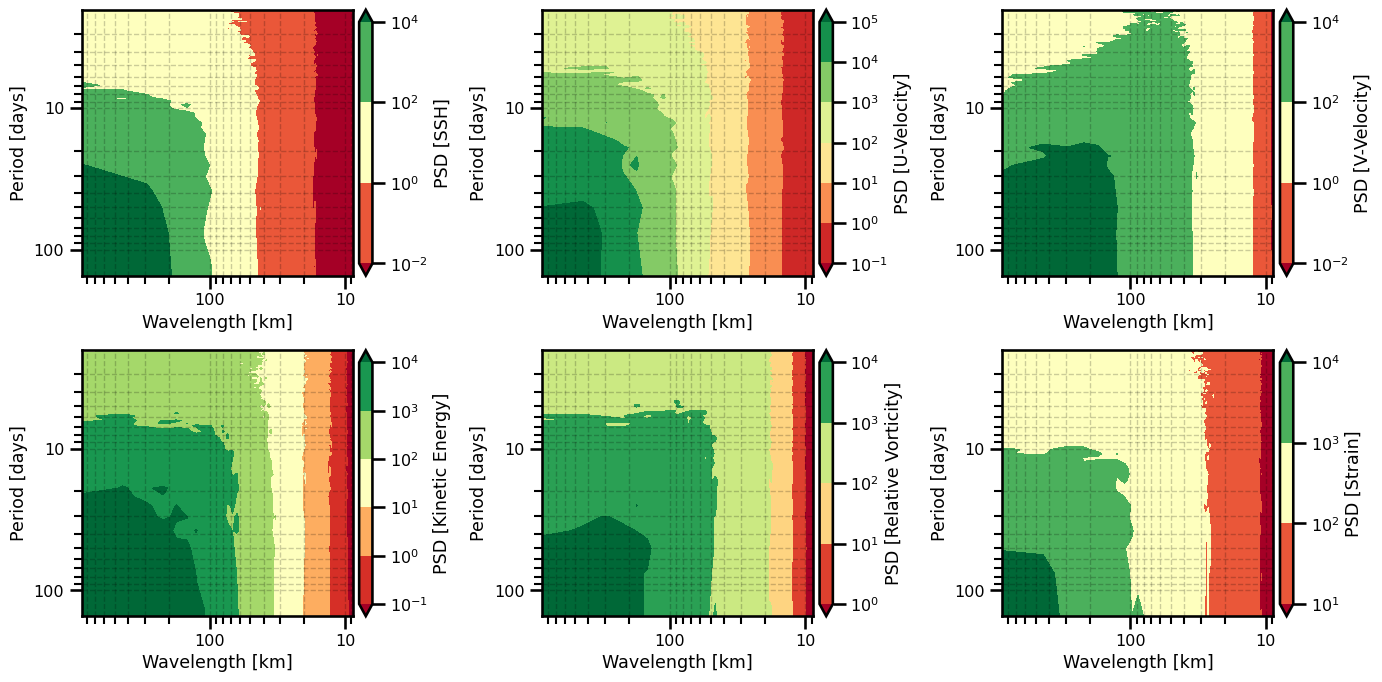

In [146]:
fig, ax = plot_analysis_psd_spacetime(ds_psd_natl60)
plt.show()

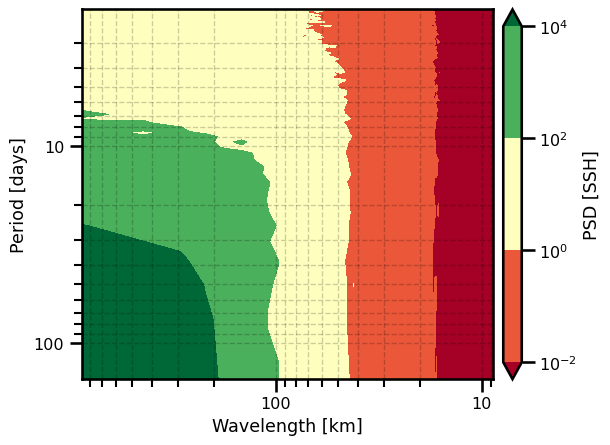

In [120]:
out = latlon_deg2m(ds_natl60.ssh, mean=True)
out = time_rescale(out, 1, "D")
out = psd_spacetime(out, ["time", "lon"])

out = psd_average_freq(out)


fig, ax, _ = plot_psd_spacetime_wavelength(out, "km", "SSH")
# fig, ax, _ = plot_psd_spacetime_wavenumber(out, "km")

plt.show()

In [61]:
from jejeqx._src.viz.xarray.psd import (
    plot_psd_spacetime_wavenumber, plot_psd_spacetime_wavelength
)

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/viz/xarray/psd.py:120: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  yscale="log",


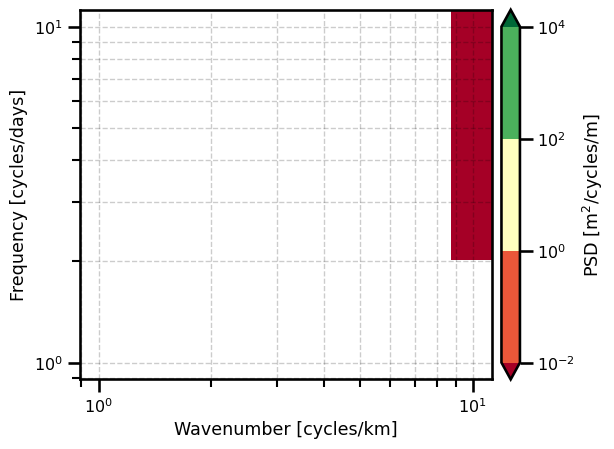

In [62]:

fig, ax, _ = plot_psd_spacetime_wavenumber(ds_psd_natl60.ssh)

plt.show()

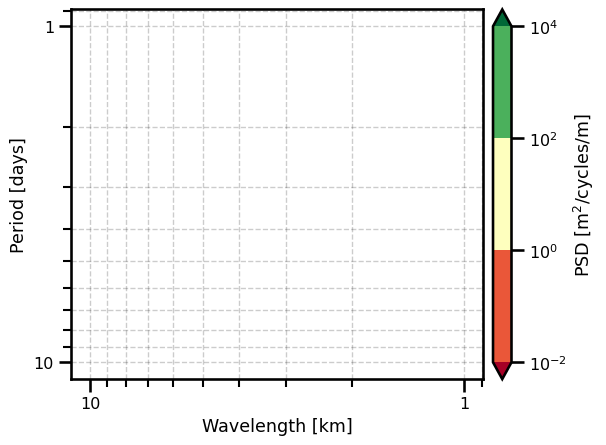

In [52]:

fig, ax, _ = plot_psd_spacetime_wavelength(ds_psd_natl60.ssh)

plt.show()

In [ ]:
import cmocean as cmo

def plot_analysis_psd_iso(ds):
    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,7))
    
    # SSH
    scale = "km"
    units = "$m^{2}$/cycles/m"
    ax[0,0] = plot_psd_spacetime(ds.ssh, units=units, scale=scale, ax=ax[0,0])

    
    # U
    scale = "km"
    units = "U-Velocity" #"$m^{2}$/cycles/m"
    ax[0,1] = plot_psd_spacetime(ds.u, units=units, scale=scale, ax=ax[0,1])
    
    # v
    scale = "km"
    units = "V-Velocity" #"$m^{2}$/cycles/m"
    ax[0,2] = plot_psd_spacetime(ds.v, units=units, scale=scale, ax=ax[0,2])
    
    # Kinetic Energy
    scale = "km"
    units = "Kinetic Energy" #"$m^{2}$/cycles/m"
    ax[1,0] = plot_psd_spacetime(ds.ke, units=units, scale=scale, ax=ax[1,0])
    
    # Relative Vorticity
    scale = "km"
    units = "U-Velocity" #"$m^{2}$/cycles/m"
    ax[1,1] = plot_psd_spacetime(ds.vort_r, units=units, scale=scale, ax=ax[1,1])
    
    
    # STRAIN
    scale = "km"
    units = "Strain" #"$m^{2}$/cycles/m"
    ax[1,2] = plot_psd_spacetime(ds.u, units=units, scale=scale, ax=ax[1,2])
    
    
    plt.tight_layout()
    return fig, ax

In [51]:
import xrft
from jejeqx._src.transforms.xarray.psd import psd_spacetime, psd_isotropic, psd_average_freq



In [22]:
ds_psd = psd_isotropic(out_ds.ssh, ["lat", "lon"])
ds_psd_avg = psd_average_freq(ds_psd)
ds_psd_avg

<xarray.DataArray (freq_r: 62)>
array([3.87546665e+03, 3.46249860e+03, 2.24204993e+03, 6.99426656e+02,
       1.98602077e+02, 8.10362204e+01, 3.32441895e+01, 1.52959066e+01,
       8.73962822e+00, 4.45487370e+00, 3.00251005e+00, 1.99411161e+00,
       1.29523308e+00, 9.16238395e-01, 6.29380168e-01, 4.48789270e-01,
       3.52031029e-01, 2.72439477e-01, 2.20550368e-01, 1.75583066e-01,
       1.43112280e-01, 1.17032174e-01, 9.36261777e-02, 7.71983561e-02,
       6.55755014e-02, 5.54353370e-02, 4.77057001e-02, 4.12002559e-02,
       3.53186355e-02, 3.09019362e-02, 2.67439172e-02, 2.35976034e-02,
       2.14761877e-02, 1.81887972e-02, 1.64030173e-02, 1.46042233e-02,
       1.32423405e-02, 1.14322848e-02, 1.04683434e-02, 9.44043758e-03,
       8.45954152e-03, 7.43763713e-03, 6.90421542e-03, 6.17548803e-03,
       5.66281392e-03, 5.27475220e-03, 4.66271242e-03, 4.29767620e-03,
       3.82494185e-03, 3.57861513e-03, 3.24190225e-03, 2.92958699e-03,
       2.78293022e-03, 2.54158261e-03, 2.39989881e-03, 2.18424653e-03,
       2.02915180e-03, 1.89025921e-03, 1.82066850e-03, 1.75375284e-03,
       1.64134469e-03, 1.59937582e-03])
Coordinates:
  * freq_r   (freq_r) float64 1.095e-06 2.407e-06 ... 8.754e-05 8.898e-05

In [23]:
from jejeqx._src.viz.xarray.psd import (
    plot_psd_isotropic_wavenumber,
    plot_psd_isotropic_wavelength,
    plot_psd_isotropic
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


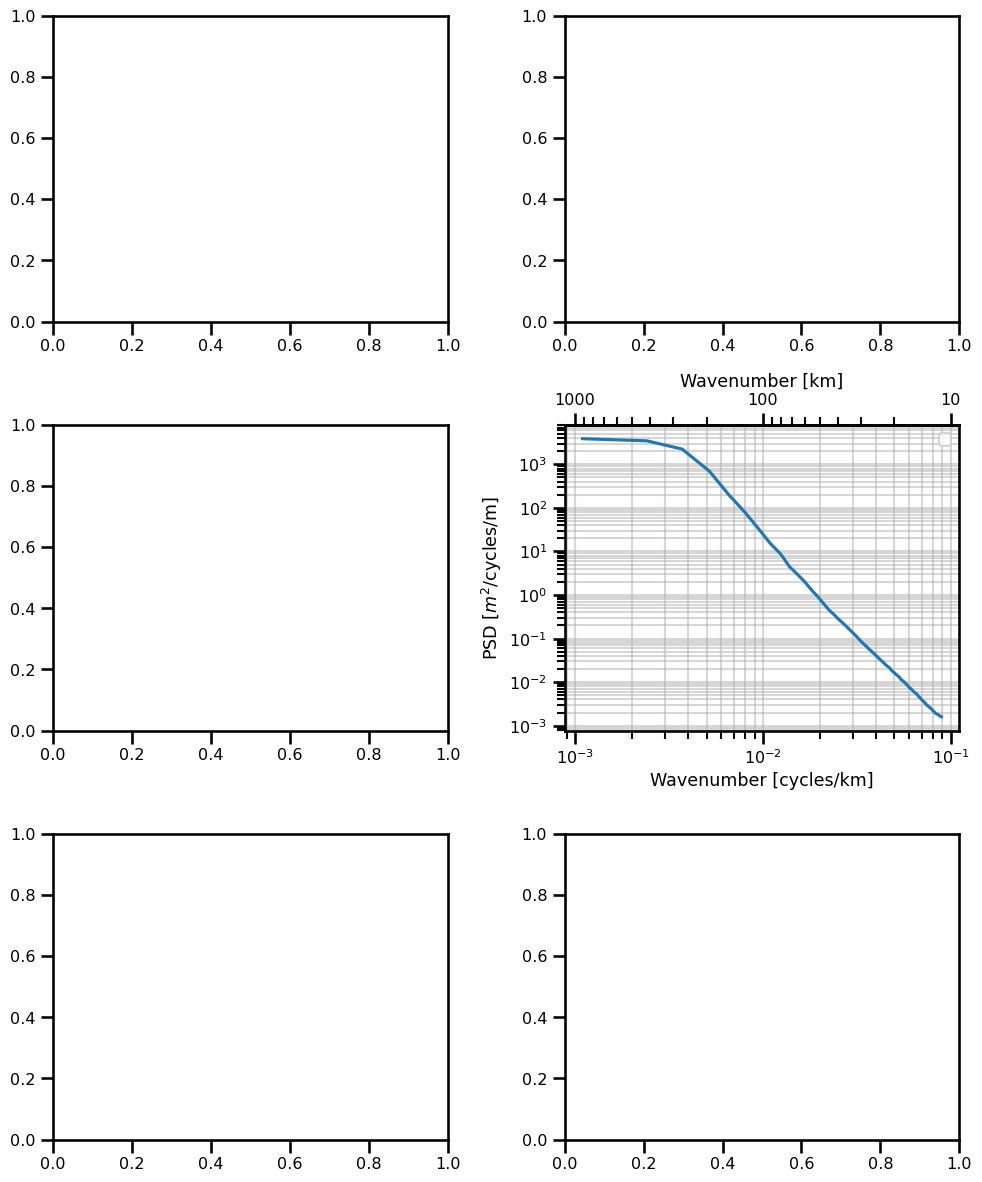

In [36]:

scale = "km"
units = "$m^{2}$/cycles/m"
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,12))

ax[1,1] = plot_psd_isotropic(ds_psd_avg, units=units, scale=scale, ax=ax[1,1])


plt.tight_layout()
plt.show()

In [243]:
plot_psd_isotropi

NameError: name 'plot_psd_isotropi' is not defined

In [206]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

def plot_psd_spacetime_wavenumber(freq_x, freq_y, psd):

    fig, ax = plt.subplots()

    locator = ticker.LogLocator()
    norm = colors.LogNorm()

    pts = ax.contourf(
        freq_x, freq_y, psd, norm=norm, locator=locator, cmap="RdYlGn", extend="both"
    )

    ax.set(
        yscale="log",
        xscale="log",
        xlabel="Wavenumber [cycles/km]",
        ylabel="Frequency [cycles/days]",
    )
    # colorbar
    fmt = ticker.LogFormatterMathtext(base=10)
    cbar = fig.colorbar(
        pts,
        pad=0.02,
        format=fmt,
    )
    cbar.ax.set_ylabel(r"PSD [m$^{2}$/cycles/m]")

    plt.grid(which="both", linestyle="--", linewidth=1, color="black", alpha=0.2)

    return fig, ax, cbar

In [ ]:
# average over latitude
mean_psd_signal = psd_signal.mean(dim="latitude").where(
    (psd_signal.freq_longitude > 0.0) & (psd_signal.freq_time > 0.0), drop=True
)


In [115]:
np.sum(out[0])

175896049.60077628 <Unit('meter')>

In [123]:

np.sum(dx), np.sum(dy)

(879480.2480038817 <Unit('meter')>, 1117508.486561053 <Unit('meter')>)

In [124]:
np.mean(dx), np.mean(dy)

(4375.523621909859 <Unit('meter')>, 5559.743714234094 <Unit('meter')>)

In [126]:
np.mean(dx) * len(dx), np.mean(dy) * len(dx)

(879480.2480038817 <Unit('meter')>, 1117508.486561053 <Unit('meter')>)

In [110]:
out = metpy.calc.lat_lon_grid_deltas(ds.lon, ds.lat)
out

(array([[4662.79337456, 4662.79337456, 4662.79337456, ..., 4662.79337456,
         4662.79337456, 4662.79337456],
        [4660.14912421, 4660.14912421, 4660.14912421, ..., 4660.14912421,
         4660.14912421, 4660.14912421],
        [4657.50132495, 4657.50132495, 4657.50132495, ..., 4657.50132495,
         4657.50132495, 4657.50132495],
        ...,
        [4072.75071706, 4072.75071706, 4072.75071706, ..., 4072.75071706,
         4072.75071706, 4072.75071706],
        [4069.44645078, 4069.44645078, 4069.44645078, ..., 4069.44645078,
         4069.44645078, 4069.44645078],
        [4066.13908545, 4066.13908545, 4066.13908545, ..., 4066.13908545,
         4066.13908545, 4066.13908545]]) <Unit('meter')>,
 array([[5559.74371423, 5559.74371423, 5559.74371423, ..., 5559.74371423,
         5559.74371423, 5559.74371423],
        [5559.74371423, 5559.74371423, 5559.74371423, ..., 5559.74371423,
         5559.74371423, 5559.74371423],
        [5559.74371423, 5559.74371423, 5559.74371423, ...